In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from utils.pair_simulator import PairSimulator
from utils.pair_zernike_estimator import PairZernikeEstimator
from lsst.ts.phosim.utils.ConvertZernikesToPsfWidth import convertZernikesToPsfWidth


In [2]:
df = pd.read_pickle("data/test_dataframe.pkl")
df = df[df["corner"] == "R00"]


In [3]:
simulator = PairSimulator(seed=42)


In [6]:
estimator = PairZernikeEstimator(stamp_size=160)


In [10]:
flux = 1e6
donut_radius = 62  # pixels
obscuration = 0.61  # fractional
donut_area = np.pi * donut_radius**2 * (1 - obscuration**2)

snrs = []
zk_true = []
zk_ml = []
zk_exp = []

for i in range(100):
    rng = np.random.default_rng(i)

    snr = rng.uniform(10, 1000)
    noise = flux / snr
    background = np.sqrt((noise**2 - flux) / donut_area)

    simulator.set_dof(rng.choice(df["dof"]))

    pair = simulator.simulate(
        intra_flux=int(flux),
        extra_flux=int(flux),
        background=background,
    )

    snrs.append(snr)
    zk_true.append(pair.opd)
    zk_ml.append(estimator.estimate(pair, "ml"))
    zk_exp.append(estimator.estimate(pair, "exp"))


snrs = np.array(snrs)
zk_true = np.array(zk_true)
zk_ml = np.array(zk_ml)
zk_exp = np.array(zk_exp)


In [16]:
a = []
b = []
for i in range(100):
    rng = np.random.default_rng(i)

    snr = rng.uniform(10, 1000)
    noise = flux / snr
    background = np.sqrt((noise**2 - flux) / donut_area)

    simulator.set_dof(rng.choice(df["dof"]))
    a.append(simulator.get_opd("R00", subtract_intrinsic=False))
    b.append(simulator.get_opd("R00", subtract_intrinsic=True))

a = np.array(a)
b = np.array(b)


In [22]:
errs_ml = np.sqrt(np.sum(convertZernikesToPsfWidth(zk_ml - a) ** 2, axis=1))
errs_exp = np.sqrt(np.sum(convertZernikesToPsfWidth(zk_exp - b) ** 2, axis=1))


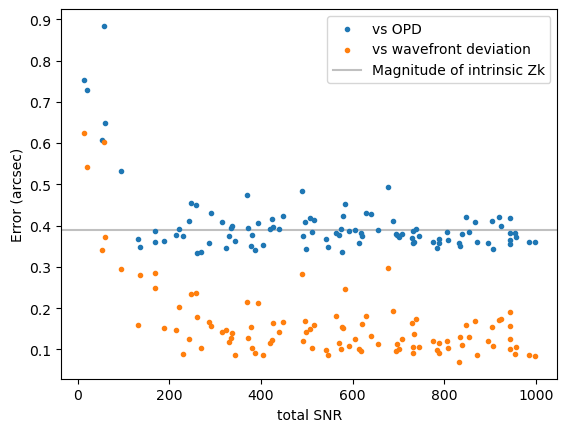

In [107]:
errs_exp = np.sqrt(np.sum(convertZernikesToPsfWidth(zk_exp - a) ** 2, axis=1))
plt.scatter(snrs, errs_exp, marker=".", label="vs OPD")

errs_exp = np.sqrt(np.sum(convertZernikesToPsfWidth(zk_exp - b) ** 2, axis=1))
plt.scatter(snrs, errs_exp, marker=".", label="vs wavefront deviation")

plt.axhline(
    0.38852043929060076, c="silver", zorder=0, label="Magnitude of intrinsic Zk"
)

plt.legend()

plt.xlabel("total SNR")
plt.ylabel("Error (arcsec)")

plt.show()


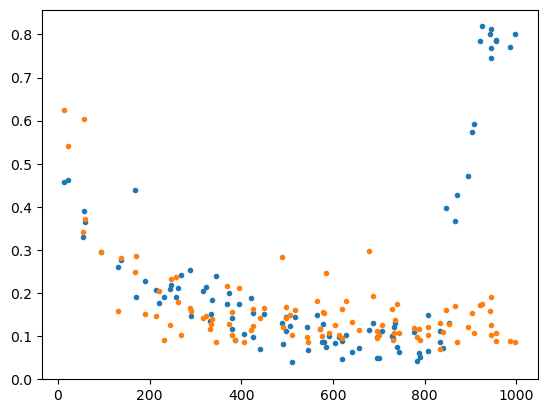

In [108]:
plt.scatter(snrs, errs_ml, marker=".")
plt.scatter(snrs, errs_exp, marker=".")


In [14]:
np.sqrt(np.sum(convertZernikesToPsfWidth(simulator.get_intrinsic_zernikes("R00")) ** 2))


0.38852043929060076

In [33]:
import numpy as np
from lsst.ts.wep.utility import DefocalType, FilterType, getConfigDir
from lsst.ts.wep.wfEstimator import WfEstimator


In [62]:
sim2 = PairSimulator(atm=False)
estimator = PairZernikeEstimator()


4


5
6
7
8
9
10
11

12
13
14
15


[Text(0.5, 1.0, '11 (hit caustic)')]

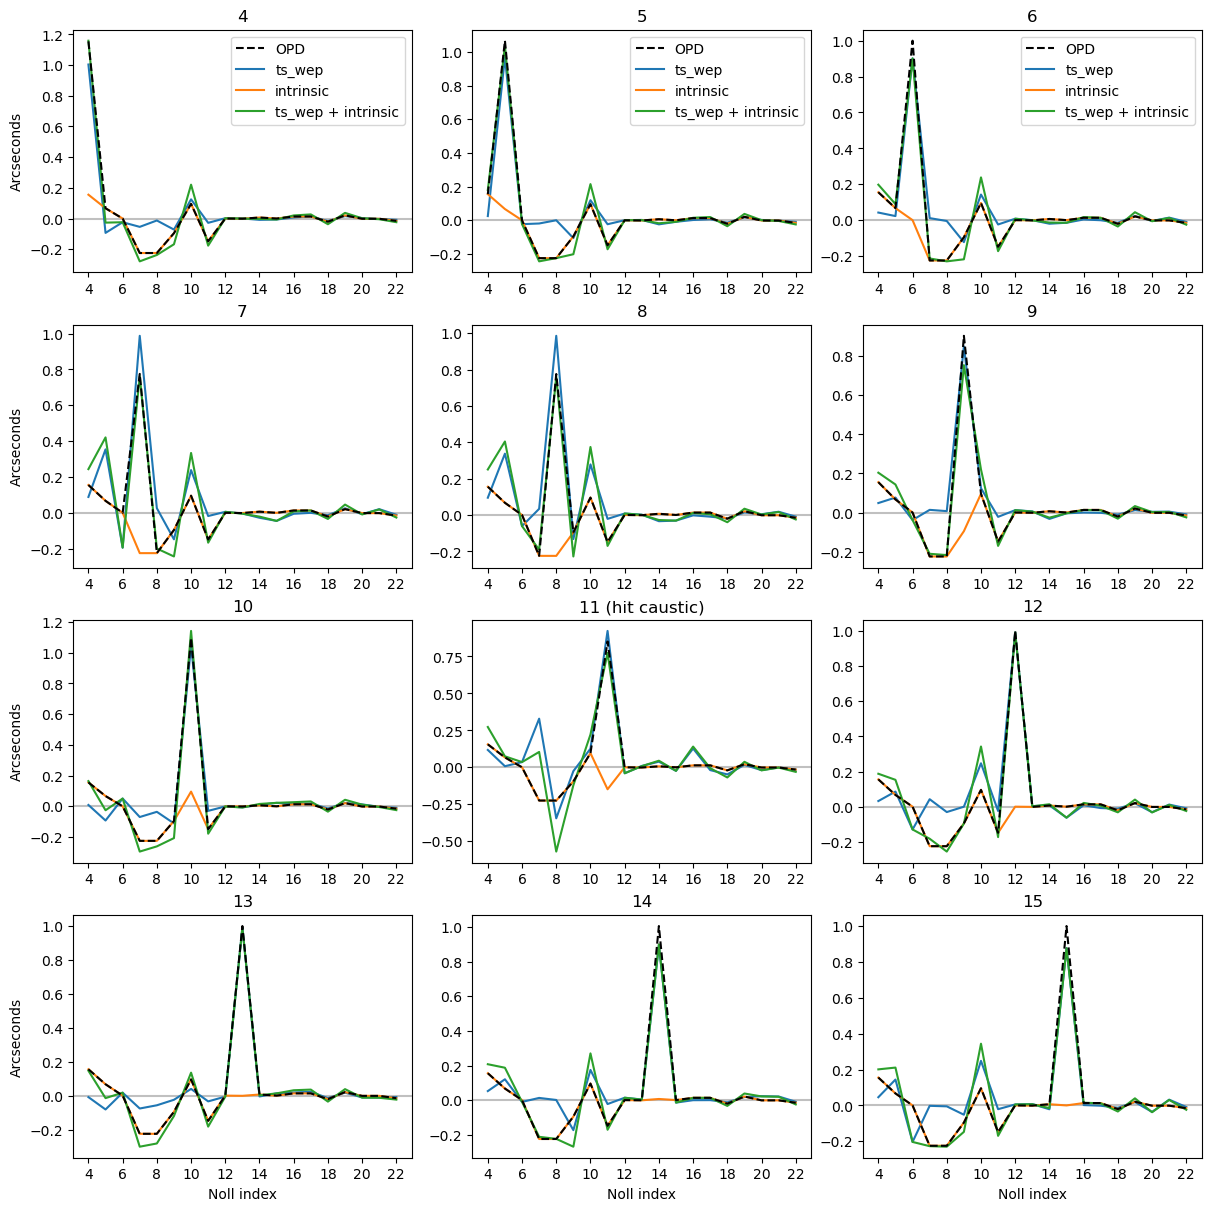

In [106]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    print(i + 4)

    opd = np.zeros(19)
    opd[i] = 1
    sim2.set_opd(opd, "R00", intrinsic_included=False)

    sim2.set_seed(i)
    pair = sim2.simulate(background=0)
    m = estimator.estimate(pair, "exp")

    ax.plot(
        np.arange(4, 23), sim2.get_opd("R00"), c="k", ls="--", label="OPD", zorder=10
    )
    ax.plot(np.arange(4, 23), m, label="ts_wep")
    ax.plot(np.arange(4, 23), sim2.get_intrinsic_zernikes("R00"), label="intrinsic")
    ax.plot(
        np.arange(4, 23),
        m + sim2.get_intrinsic_zernikes("R00"),
        label="ts_wep + intrinsic",
    )
    ax.axhline(0, c="silver", zorder=0)

    ax.set(title=i + 4, xticks=np.arange(4, 23, 2))

for ax in axes[:, 0]:
    ax.set(ylabel="Arcseconds")
for ax in axes[-1, :]:
    ax.set(xlabel="Noll index")
for ax in axes[0, :]:
    ax.legend()

axes[2, 1].set(title="11 (hit caustic)")


In [109]:
ml_estimator = WfEstimator(f"{getConfigDir()}/cwfs/algo")
ml_estimator.config(
    sizeInPix=160,
    algo="ml",
    mlFile="/astro/store/epyc/users/jfc20/ml-aos/models/v0_2023-06-19_09:41:19.pt",
)
exp_estimator = WfEstimator(f"{getConfigDir()}/cwfs/algo")
exp_estimator.config(
    sizeInPix=160,
    algo="exp",
)


In [113]:
pair.intra.stamp_size = 160
pair.extra.stamp_size = 160


In [172]:
import time

start = time.time()
print("hello")
end = time.time()
print(end - start)


hello
0.00015616416931152344


In [173]:
ml_time = []
for i in range(100):
    ml_estimator.reset()
    ml_estimator.setImg(
        pair.intra.angle,
        DefocalType.Intra,
        filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
        image=pair.intra.stamp,
    )
    ml_estimator.setImg(
        pair.extra.angle,
        DefocalType.Extra,
        filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
        image=pair.extra.stamp,
    )

    start = time.time()
    ml_estimator.calWfsErr()
    end = time.time()
    ml_time.append(end - start)


In [174]:
exp_time = []
for i in range(100):
    exp_estimator.reset()
    exp_estimator.setImg(
        pair.intra.angle,
        DefocalType.Intra,
        filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
        image=pair.intra.stamp,
    )
    exp_estimator.setImg(
        pair.extra.angle,
        DefocalType.Extra,
        filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
        image=pair.extra.stamp,
    )

    start = time.time()
    exp_estimator.calWfsErr()
    end = time.time()
    exp_time.append(end - start)


In [175]:
np.median(ml_time), np.mean(ml_time), np.std(ml_time)


(0.08842480182647705, 0.43094650268554685, 1.2170233104230423)

In [176]:
np.median(exp_time), np.mean(exp_time), np.std(exp_time)


(3.3507200479507446, 3.080648798942566, 0.9519561752006528)

In [181]:
3 / 40


0.075

In [179]:
np.median(exp_time) / np.median(ml_time)


37.89344141846228

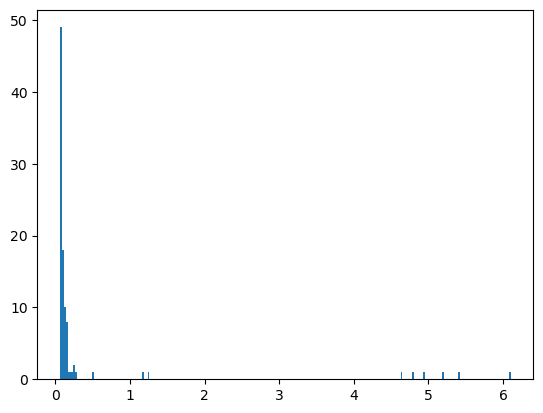

In [177]:
plt.hist(ml_time, bins="auto")


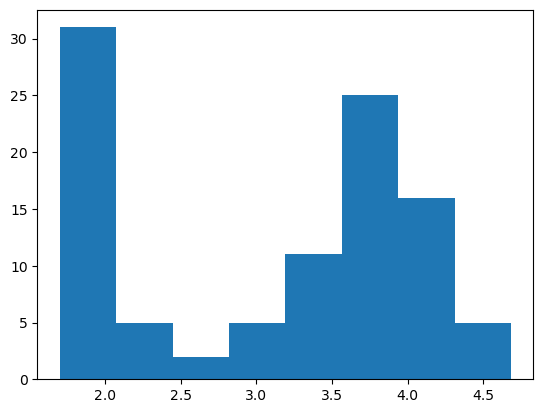

In [178]:
plt.hist(exp_time, bins="auto")


In [169]:
ml_estimator.reset()
ml_estimator.setImg(
    pair.intra.angle,
    DefocalType.Intra,
    filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
    image=pair.intra.stamp,
)
ml_estimator.setImg(
    pair.extra.angle,
    DefocalType.Extra,
    filterLabel=FilterType[f"LSST_{pair.band.capitalize()}"],
    image=pair.extra.stamp,
)


In [170]:
%time exp_estimator.calWfsErr()

CPU times: user 0 ns, sys: 52 µs, total: 52 µs
Wall time: 72.2 µs


array([  45.69128135,  144.0841531 , -203.59308417,   -2.27596528,
         -5.17197872,  -51.86737809,  248.44152541,  -20.99168263,
          5.36339111,    7.5404526 ,  -21.5402998 ,  876.66200424,
          1.94912563,   -1.64528321,  -13.20860392,   18.82594634,
        -36.34670989,   32.08314781,   -8.89399298])

In [ ]:
100ms

In [155]:
2 / 100e-3


20.0

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from utils.pair_simulator import PairSimulator


In [2]:
simulator = PairSimulator()


In [3]:
pair = simulator.simulate()


In [12]:
simulator.set_dof(np.random.normal(size=50))


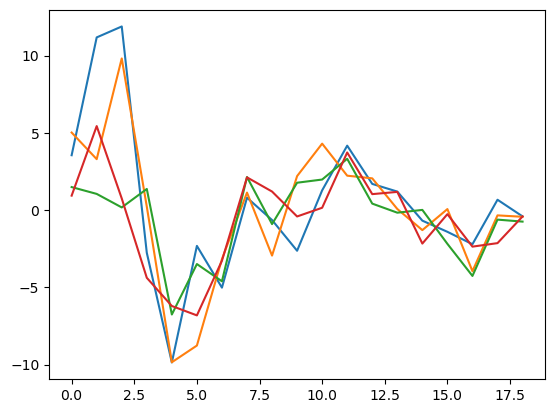

In [19]:
plt.plot(simulator.get_wf_dev("R00"))
plt.plot(simulator.get_wf_dev("R40"))
plt.plot(simulator.get_wf_dev("R44"))
plt.plot(simulator.get_wf_dev("R04"))


In [14]:
simulator.get_wf_dev("R40")


array([ 5.01688736,  3.29524322,  9.81135679,  0.22597069, -9.84597952,
       -8.76535773, -3.17274522,  1.13135548, -2.94424764,  2.19850316,
        4.29975828,  2.22574626,  2.05315326,  0.07193313, -1.29614359,
        0.06426366, -3.95188787, -0.34241459, -0.43409981])

In [15]:
simulator.get_wf_dev("R44")


array([ 1.48837393,  1.04679156,  0.17185797,  1.36562172, -6.75584116,
       -3.49155085, -4.60717223,  2.13996714, -0.90670292,  1.77025826,
        1.97640874,  3.3182577 ,  0.41821966, -0.16846674,  0.01140177,
       -2.18414915, -4.26130724, -0.61731026, -0.74609921])

In [16]:
simulator.get_wf_dev("R04")


array([ 0.93441628,  5.43385018,  0.75332086, -4.38098179, -6.20642562,
       -6.81380777, -3.27788229,  2.11697042,  1.19973937, -0.41351978,
        0.15018782,  3.72720756,  1.03227835,  1.17677722, -2.16699079,
       -0.26330172, -2.36513536, -2.13852859, -0.41255782])